# **High-Frequency Quasi-Periodic Oscillations in the Solar Corona Observed with High-Frame-Rate Imaging During the 2023 Total Solar Eclipse**
### **Data Processing and Analysis Notebook**

**Authors**: [Yu Liang]
**Affiliation**: [Shanghai Astronomical Observatory, Chinese Academy of Sciences, Shanghai 200030, China]  
**Contact**: [yuliang@shao.ac.cn]  
**Last Updated**: [2024-12-10]  

---

### **Notebook Overview**

These Jupyter Notebook documents the processing and analysis of observational data collected during the 2023 total solar eclipse. The primary objectives of this Notebook include:

1. Preprocessing of raw white-light corona imaging data (dark field subtraction, flat field correction, and temporal registration).
2. Application of wavelet analysis to detect high-frequency quasi-periodic oscillations (HFQPOs).
3. Visualizations of the solar corona and statistical results for Sun-as-a-star analysis.

---

### **Dependencies**

The analysis relies on the following Python libraries (compatible versions):  
- `numpy==1.2.43`  
- `pandas==1.5.1`  
- `scikit-image==0.20.0`  
- `matplotlib==3.7.1`  
- `astropy==5.1.1`  
- `opencv-python==4.7.0.72`  
- `Pillow==9.2.0`  
- `scipy==1.13.1`  


<!-- A complete list of dependencies can be found in the accompanying `requirements.txt`. -->

---

### **Data Source**

- **Observation Site**: Learmonth Airport, Australia  
- **Instrument**: iPhone with 565 nm filter, sampling at 240 fps, frams width * height: 720.0 * 1280.0, image shape:(1280, 720, 3)  
- **Date**: April 20, 2023  

---

### **Main Structure**

- **Section 1**: Data loading and inspection  
- **Section 2**: Preprocessing (dark field, flat field, and registration)  
- **Section 3**: Wavelet analysis and signal detection  
- **Section 4**: Results visualization and discussion  

---
### **Notebook 1.1**
#### File name sort. 
- input: *.jpg
- output: *.jpg

STEP 1: file name sort. 
- To prevent file sorting errors, we standardized the file naming format by padding, for instance, renaming $\texttt{image1.jpg}$ to $\texttt{image00001.jpg}$. This approach ensures proper file sequencing during subsequent batch data processing.


In [1]:
import pandas as pd
import os
import numpy as np
from astropy.io import fits
import skimage.io as io 

## Mathmatics libraries
import numpy as np
import math

## Image Processing libraries
import skimage
from skimage import exposure
import scipy.misc as misc
import rawpy
import imageio
## Visual and plotting libraries
import matplotlib.pyplot as plt
from PIL import Image

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
path0 = '/Volumes/WD1T/share/TSE2023/'                                      # Parent folder
pathmc = '/Volumes/WD1T/share/TSE2023/iPhone/raw/'                          # input dir of the cut moive of the original data, to aviod the 

dir1  = path0 + 'iPhone/result/m2pic/'                                      # output dir for saving the frames extracted by the moive
if not os.path.exists(dir1):
    os.makedirs(dir1)

In [3]:
pathd = dir1
listd = os.listdir(pathd)
listd.sort()
print(listd[0])
print(len(listd))

image_00000.jpg
13301


/Volumes/WD1T/share/TSE2023/iPhone/result/m2pic/image_02418.jpg


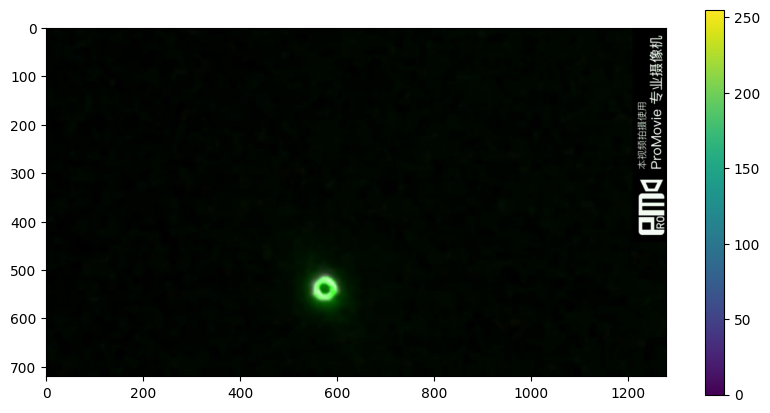

In [4]:
st1 = len(listd) - 240* 54 - 323  + 240 *10     # The 10th seconds of the total solar eclipse
from PIL import Image
print(pathd + listd[st1])
## Reading a RAW file:
img0 = Image.open(pathd + listd[st1])
plt.figure(figsize=(10,5))
plt.imshow(img0)
plt.colorbar()
plt.show()

In [5]:
print("img_PIL:",img0)
img0np = np.array(img0)
m,n,o = img0np.shape
img0g = np.zeros([m,n],dtype='uint16')
#img0g = img0np[:,:,0] + img0np[:,:,1] +img0np[:,:,2]

img0np.dtype, img0np.shape,img0g.dtype, img0g.shape

img_PIL: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x7FA1F9001520>


(dtype('uint8'), (720, 1280, 3), dtype('uint16'), (720, 1280))

In [6]:
print("img_PIL:",img0)
img0np = np.array(img0)
m,n,o = img0np.shape
img0g = ((img0np[:,:,0]/ 3 + img0np[:,:,1]/ 3+ img0np[:,:,2]/ 3) )#.astype(np.uint8)
#img0g = img0np[:,:,0] +img0np[:,:,1]+img0np[:,:,2]
img0g.dtype

img_PIL: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x7FA1F9001520>


dtype('float64')

In [7]:
!pwd

/Users/liangyu/Library/CloudStorage/OneDrive-USTC/codes/gitcode/github/eclipse2023


In [8]:
roi = np.load('./output/roi.npy')
rc, cc, idxrange = roi[0], roi[1], roi[2]

In [9]:
# # 更新绘图参数，增大字体
# plt.rcParams.update({
#     'font.size': 16,            # 全局字体大小
#     'axes.titlesize': 18,       # 坐标轴标题字体大小
#     'axes.labelsize': 16,       # 坐标轴标签字体大小
#     'xtick.labelsize': 14,      # x轴刻度标签字体大小
#     'ytick.labelsize': 14,      # y轴刻度标签字体大小
#     'legend.fontsize': 16,      # 图例字体大小
#     'figure.titlesize': 20,     # 图像标题字体大小
#     'font.family': 'serif',     # 字体设置为衬线体
#     'mathtext.fontset': 'stix', # 数学字体设置
# })

# # 设置画布
# plt.figure(figsize=(16, 8),dpi=300)
# plt.suptitle('Central Area of the Solar Corona', fontsize=20)

# # 左侧图像：原始图像
# plt.subplot(121)
# plt.imshow(img0, origin='lower')
# plt.title('Original Image', fontsize=18)
# plt.axis('off')

# # 在左侧图中标注右侧视场
# rect_x = cc - idxrange  # 矩形左下角 x 坐标
# rect_y = rc - idxrange  # 矩形左下角 y 坐标
# rect_width = 2 * idxrange  # 矩形宽度
# rect_height = 2 * idxrange  # 矩形高度
# plt.gca().add_patch(plt.Rectangle((rect_x, rect_y), rect_width, rect_height, 
#                                   edgecolor='red', facecolor='none', linewidth=2.5, linestyle='--'))
# plt.text(rect_x + rect_width / 2, rect_y - 15, 'Zoomed Region', 
#          color='red', fontsize=16, ha='center', va='top')

# # 右侧图像：标准化后的灰度复合图
# plt.subplot(122)
# plt.imshow(img0g[rc-idxrange:rc+idxrange, cc-idxrange:cc+idxrange], cmap='gray', origin='lower')
# plt.title('Prepropressed Gray Image', fontsize=18)
# plt.axis('off')

# # 调整布局并保存
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # 为标题留出空间
# pathfigs = './output/'
# plt.savefig(pathfigs + 'RGB-gray.png', bbox_inches='tight')
# plt.show()


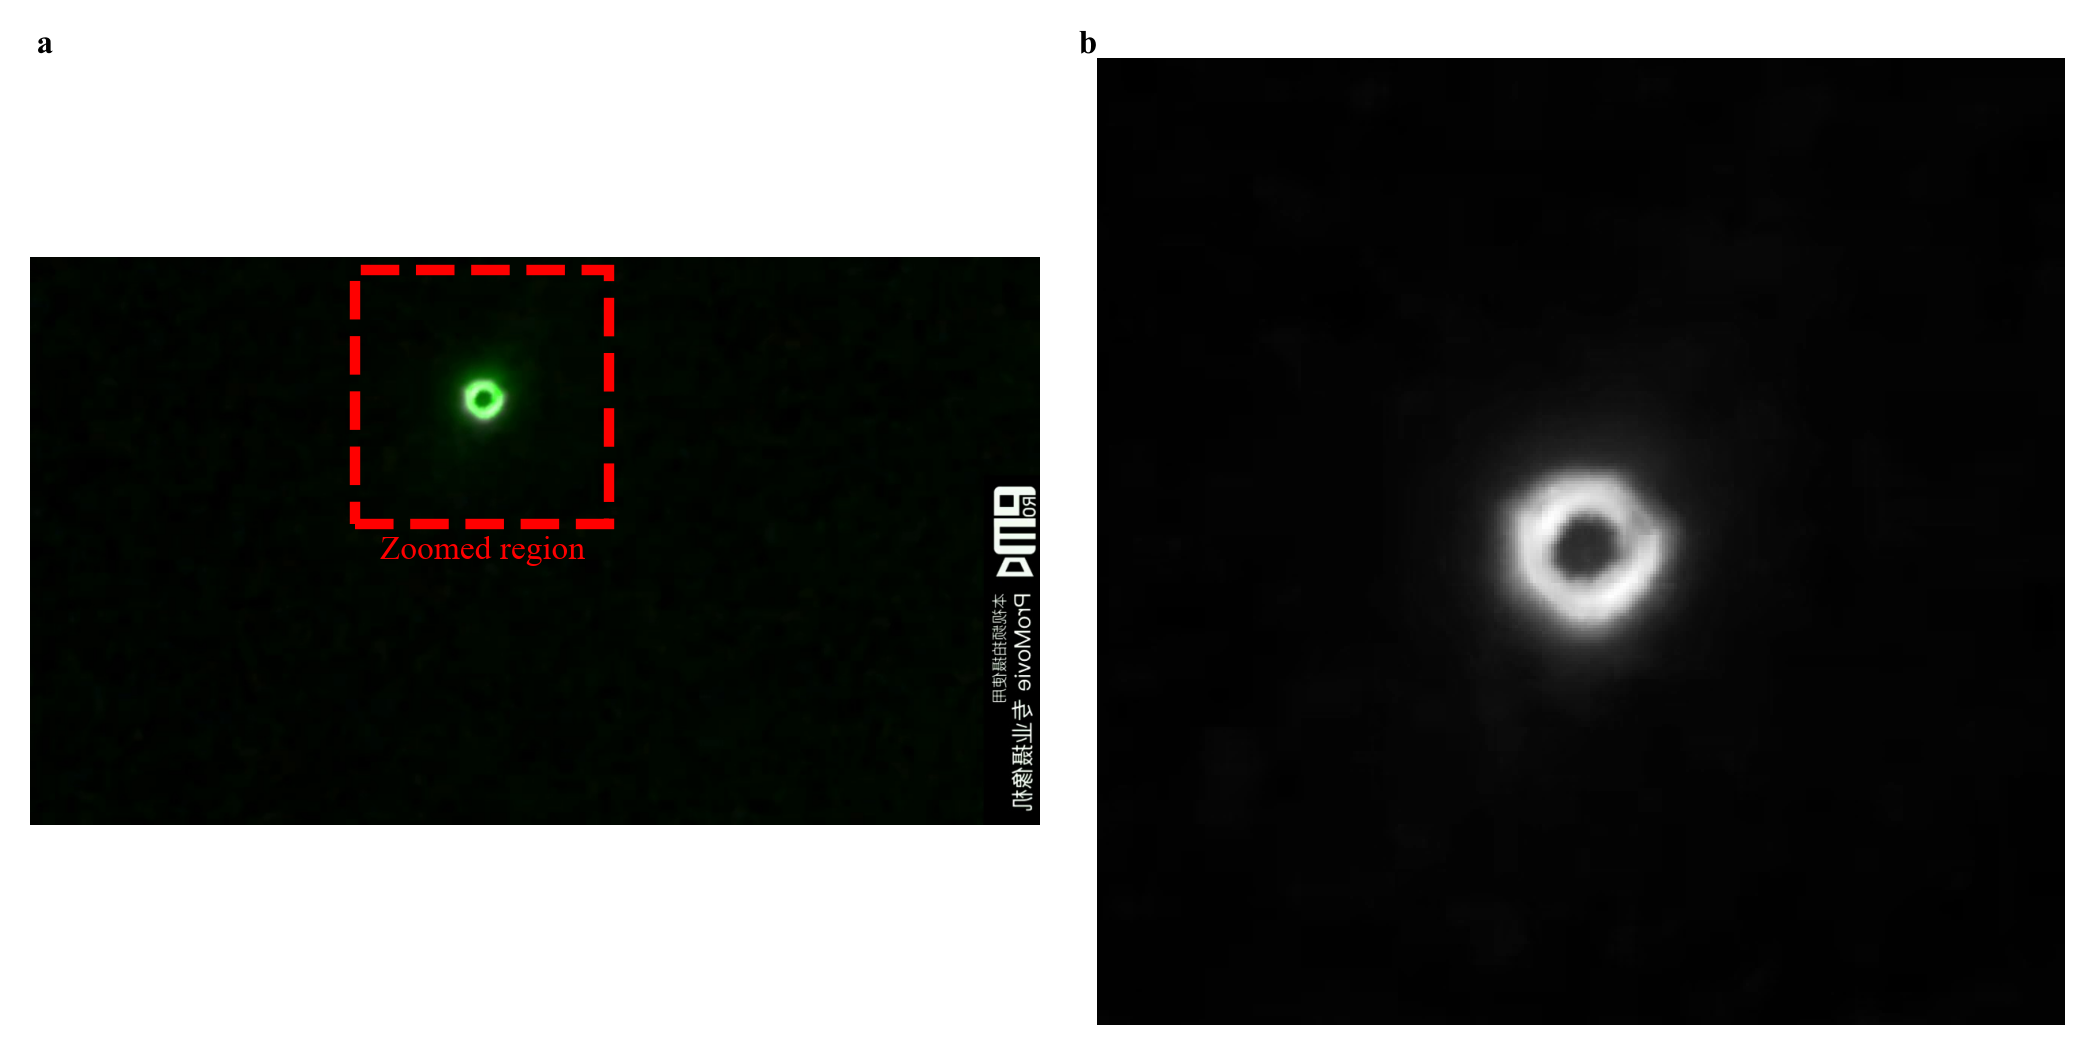

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Update plotting parameters, adjust font size and unify format
plt.rcParams.update({
    'font.size': 8,              # Global font size
    'axes.titlesize': 8,         # Axis title font size
    'axes.labelsize': 8,         # Axis label font size
    'xtick.labelsize': 8,        # x-axis tick label font size
    'ytick.labelsize': 8,        # y-axis tick label font size
    'legend.fontsize': 8,        # Legend font size
    'figure.titlesize': 8,       # Figure title font size
    'font.family': 'serif',      # Font set to serif
    'font.serif': ['Times New Roman'],  # Use Times New Roman font
    'mathtext.fontset': 'stix',  # Set math font
})

# Set up the canvas
plt.figure(figsize=(7.09,3.5), dpi=300)

# Left image: Original image
plt.subplot(121)
plt.imshow(img0, origin='lower')
plt.axis('off')  # No axis for the image

# Mark subplot 'a' in the left image
ss = 8  # Subplot label font size
plt.gcf().text(0.02, 0.96, 'a', fontsize=ss, fontweight='bold', color='black',
               path_effects=[path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])

# Add rectangle for zoomed region
rect_x = cc - idxrange  # Rectangle lower-left x coordinate
rect_y = rc - idxrange  # Rectangle lower-left y coordinate
rect_width = 2 * idxrange  # Rectangle width
rect_height = 2 * idxrange  # Rectangle height
plt.gca().add_patch(plt.Rectangle((rect_x, rect_y), rect_width, rect_height, 
                                  edgecolor='red', facecolor='none', linewidth=2.5, linestyle='--'))
plt.text(rect_x + rect_width / 2, rect_y - 15, 'Zoomed region', 
         color='red', fontsize=8, ha='center', va='top')

# Right image: Preprocessed gray image
plt.subplot(122)
plt.imshow(img0g[rc-idxrange:rc+idxrange, cc-idxrange:cc+idxrange], cmap='gray', origin='lower')
plt.axis('off')  # No axis for the image

# Mark subplot 'b' in the right image
plt.gcf().text(0.51, 0.96, 'b', fontsize=ss, fontweight='bold', color='black',
               path_effects=[path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])

# Adjust layout and save
plt.tight_layout(rect=[0, 0, 1, 0.99])  # Leave space for the title
pathfigs = './output/'
plt.savefig(pathfigs + 'RGB-gray.png', bbox_inches='tight')
plt.show()
